# Autoencoder (AE) and denoising AE

## Introduction

In the past lab we have used the low-level API of PyTorch to implement an MLP. We trained the model to fit a synthetic data set and we experimented with different batch sizes and learning rates.

In this lab we will use one of PyTorch high-level APIs: `torch.nn`. This time we will experiment on more complex and natural datasets: MNIST or Fashion-MNIST.


## Objectives
- Learn to use the PyTorch `nn` API
- Build, train and use a simple MLP
- Build, train and use a more advanced CNN

## Outline
- Download MNIST
- Create and train a dense autoencoder (AE) that encodes-decodes images
- Plot images and reconstructions
- Refine the model with an output activation
- Visualize the first two dimensions of the codes
- Visualize all dimensions of the codes using PCA or TSNE
- Generate random images
- Interpolate between two images
- Classify images by code
- CNN Autoencoder
- Denoising AE with Gaussian noise

Optionals:
- Replace the encoder with a MobileNet v2 backbone
- Create a denoising AE with masks
- Create a denoising AE with an exotic distortion of choice
- Create a superresolution AE


## Getting started

We will first import all necessary modules:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

## Exercise 1 : MNIST preparation

Prepare the datasets for the MNIST corpus.

In [2]:
### BEGIN SOLUTION

train_set = torchvision.datasets.MNIST(
    root="data/mnist",
    train=True,
    download=True,
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5, ))])
    
)


test_set = torchvision.datasets.MNIST(
    root="data/mnist",
    train=True,
    download=False,
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])
    )


inputs = next(iter(train_set))

print(inputs[0].shape)





### END SOLUTION

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw

torch.Size([1, 28, 28])


## Exercise 2 : Feed-forward Autoencoder
An autoenoder (AE) is composed of two subnetworks, an **encoder** that transforms the input image into a multidimensional vector known as the **code** (with size decided by the user), and a **decoder** subnetwork that reconstructs the input image from the code.

Implement an AE with a 2 dense layer encoder and 2 dense layer decoder, with 128 hidden units each. The code should have 32 dimensions.

DenseAutoEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Unflatten(dim=1, unflattened_size=torch.Size([1, 28, 28]))
  )
)


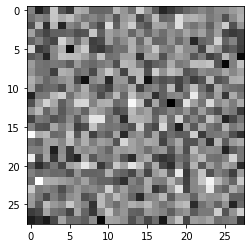

In [3]:
class DenseAutoEncoder(nn.Module):
    def __init__(self, input_shape, code_dim=32, hidden_dim=128):
        super().__init__()
        
        input_dim = torch.prod(torch.tensor(input_shape))
        
        self.encoder = nn.Sequential(
            ### BEGIN SOLUTION
            nn.Flatten(1),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, code_dim),
            
            ### END SOLUTION
            )
        
        self.decoder = nn.Sequential(
            ### BEGIN SOLUTION
            nn.Linear(code_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Unflatten(1, input_shape),
            # nn.Sigmoid()            
            ### END SOLUTION
            )

    def forward(self, ims):
        ### BEGIN SOLUTION
        # Compute the codes using the encoder
        codes = self.encoder(ims)

        # Compute the estimated images using the decoder
        ims_est = self.decoder(codes)
        ### END SOLUTION
        return ims_est, codes


input_shape = train_set[0][0].shape
print(DenseAutoEncoder(input_shape, code_dim=32, hidden_dim=128))

inputs = train_set[0][0]
model = DenseAutoEncoder(input_shape, code_dim=32, hidden_dim=128)

with torch.no_grad():
    model.eval()
    ims_est, codes = model(inputs)

plt.imshow(ims_est[0][0], cmap='gray')
plt.show()

## Exercise 3 : Training the AE
Write a function that trains the autoencoder.

In [36]:
def train(model, dataloader, nepochs=1, lr=1e-3):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.train()

    ### BEGIN SOLUTION
    # Create the Adam optimizer with weight_decay=1e-5
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # Create the MSE criterion
    criterion = nn.MSELoss()
    ### END SOLUTION

    # Move model and criterion to the device
    
    model = model.to(device)
    criterion = criterion.to(device)

    # Variables to track the running average of the loss
    running_loss = 0.
    running_samples = 0

    for epoch in range(nepochs):
        model.train()
        for it, data in enumerate(dataloader):
            ### BEGIN SOLUTION
            # Unpack the data into ims and labels
            ims = data[0]
            labels = data[1]
            
            # Move ims into the device
            ims.to(device)

            # Zero the gradients
            with torch.no_grad():           
                optimizer.zero_grad()

            # Forward pass of the model
            ims_est, codes = model(ims)
            
            # Compute the loss
            myloss = criterion(ims_est, ims)
            
            ### END SOLUTION

            running_loss += myloss
            running_samples += ims.shape[0]

            if it % 100 == 0 and it!=0:
                print(f'ep: {epoch}, it: {it}, loss : {running_loss/100:.5f}')
                running_loss = 0
                running_samples = 0

            ### BEGIN SOLUTION
            # Compute the gradients
            myloss.backward()
            
            # Perform optimization step
            with torch.no_grad():
                optimizer.step()

        # model.eval()
        # for it, data in enumerate(dataloader):
        #     IMAGE = data[0]
            
        #     with torch.no_grad():
        #         ims_est, codes = model(IMAGE)
        #         plot_image_row(ims_est)
        #         # plt.imshow(ims_est[0][0], cmap='gray')
        #         # plt.show()
        #     break
        # #     ### END SOLUTION

input_shape = train_set[0][0].shape
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle = False)
model_1 = DenseAutoEncoder(input_shape, code_dim=32, hidden_dim=128)
train(model_1, train_loader, nepochs=3, lr=1e-3)

ep: 0, it: 100, loss : 0.29483
ep: 0, it: 200, loss : 0.14818
ep: 0, it: 300, loss : 0.12355
ep: 0, it: 400, loss : 0.10679
ep: 0, it: 500, loss : 0.09601
ep: 0, it: 600, loss : 0.08896
ep: 0, it: 700, loss : 0.08441
ep: 0, it: 800, loss : 0.08281
ep: 0, it: 900, loss : 0.07821
ep: 1, it: 100, loss : 0.10475
ep: 1, it: 200, loss : 0.07368
ep: 1, it: 300, loss : 0.07566
ep: 1, it: 400, loss : 0.07296
ep: 1, it: 500, loss : 0.07229
ep: 1, it: 600, loss : 0.07110
ep: 1, it: 700, loss : 0.07078
ep: 1, it: 800, loss : 0.07142
ep: 1, it: 900, loss : 0.06939
ep: 2, it: 100, loss : 0.09512
ep: 2, it: 200, loss : 0.06795
ep: 2, it: 300, loss : 0.07049
ep: 2, it: 400, loss : 0.06875
ep: 2, it: 500, loss : 0.06892
ep: 2, it: 600, loss : 0.06824
ep: 2, it: 700, loss : 0.06804
ep: 2, it: 800, loss : 0.06895
ep: 2, it: 900, loss : 0.06708


## Exercise 4 : Plot reconstructions

Create a function `plot_image_row` to visualize a set of images as a row using `plt.subplots`.

We then provide a function `plot_images` that plots the image sets past as arguments in consecutive rows by using `plot_image_row`.

Create a function `forward_one_batch` which given a dataset creates a batch and runs the model to produce images.

Finally create a function `ex_compare_reconstructions` which takes two datasets (usually train and test), runs the model on a batch and plots the reconstructions under the ground-truths

Train set


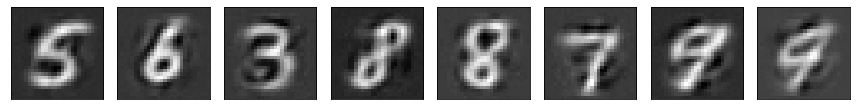

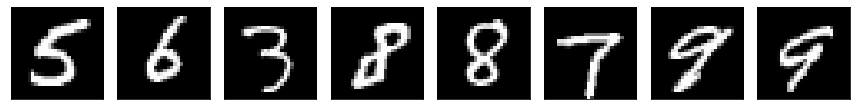

Test set


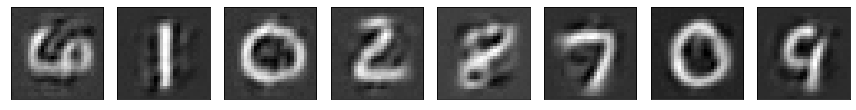

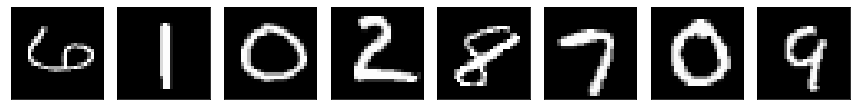

In [116]:
def plot_image_row(ims):
    # Detach, move to CPU and convert tensors to numpy arrays
    # print(type(ims))
    if not type(ims) == list:

        ims = ims.squeeze(1).detach().cpu().numpy()
    
        num_of_images = ims.shape[0]
    else:
        num_of_images = len(ims)
    if num_of_images>16:
        num_of_images=16
    fig = plt.figure(figsize=(12, num_of_images*12))
    ### BEGIN SOLUTION
    for i, image in enumerate(ims):
        # print(i)
        # print(image.shape)
        ax = fig.add_subplot(1, num_of_images, i+1)
        ax.imshow(image, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i==(num_of_images-1):
            break
            
    ### END SOLUTION

    plt.tight_layout()
    plt.show()

def plot_images(*args):
    for arg in args:
        
        plot_image_row(arg)
    
def forward_one_batch(model, dataset, batch_size):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device)

    model.eval()

    ### BEGIN SOLUTION
    testing_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, pin_memory=True, num_workers=2, shuffle = True)

    ims, labels = next(iter(testing_loader))

    ims_est, codes = model(ims)   



    ### END SOLUTION

    return ims, codes, ims_est, labels

def ex_compare_reconstructions(model, train_set, test_set):
    print('Train set')
    ### BEGIN SOLUTION
    batch_size = 8
    ims, codes, ims_est, labels = forward_one_batch(model, train_set, batch_size)
    plot_images(ims_est, ims)


    ### END SOLUTION

    print('Test set')
    ### BEGIN SOLUTION
    batch_size = 8
    ims, codes, ims_est, labels = forward_one_batch(model, test_set, batch_size)
    plot_images(ims_est, ims)


    ### END SOLUTION

ex_compare_reconstructions(model_1, train_set, test_set)

## Exercise 5 : Range of pixels

If we look carefully we observe the range of values for the pixels of the estimated images is different from that of the input images to the model.

For a batch of 64 images of the train set, **print the min and max values** of the images inputed to the model versus those estimated by it.

In [18]:
### BEGIN SOLUTION

input = next(iter(train_loader))
print((input[0].shape))
print(torch.min(input[0]))
print(torch.max(input[0]))

### END SOLUTION

torch.Size([64, 1, 28, 28])
tensor(-1.)
tensor(1.)


## Exercise 6 : Output activation function

Select an activation function for the output layer that better suits our data.
- Modify the model to add this activation function
- Train the new model for 3 epoch
- Plot the images

In [44]:
class DenseAutoEncoderOutAct(nn.Module): 
    def __init__(self, input_shape, code_dim=32, hidden_dim=128):
        super().__init__()

        input_dim = torch.prod(torch.tensor(input_shape))
        
        self.encoder = nn.Sequential(
            ### BEGIN SOLUTION
             ### BEGIN SOLUTION
            nn.Flatten(1),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, code_dim),
            
            ### END SOLUTION
            )
 
        self.decoder = nn.Sequential(
            ### BEGIN SOLUTION
            nn.Linear(code_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Unflatten(1, input_shape),
            nn.Sigmoid()            
            ### END SOLUTION
            )

    def forward(self, ims):
        ### BEGIN SOLUTION
        # Compute the codes using the encoder
        codes = self.encoder(ims)

        # Compute the estimated images using the decoder
        ims_est = self.decoder(codes)
        ### END SOLUTION
        return ims_est, codes
        
input_shape = train_set[0][0].shape
model_2 = DenseAutoEncoderOutAct(input_shape, code_dim=32, hidden_dim=128)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle = True)
train(model_2, train_loader, nepochs=15, lr = 1e-3)

ep: 0, it: 100, loss : 1.02162
ep: 0, it: 200, loss : 0.92473
ep: 0, it: 300, loss : 0.92524
ep: 0, it: 400, loss : 0.92532
ep: 0, it: 500, loss : 0.92561
ep: 0, it: 600, loss : 0.92528
ep: 0, it: 700, loss : 0.92551
ep: 0, it: 800, loss : 0.92558
ep: 0, it: 900, loss : 0.92557
ep: 1, it: 100, loss : 1.27688
ep: 1, it: 200, loss : 0.92567
ep: 1, it: 300, loss : 0.92544
ep: 1, it: 400, loss : 0.92521
ep: 1, it: 500, loss : 0.92531
ep: 1, it: 600, loss : 0.92510
ep: 1, it: 700, loss : 0.92536
ep: 1, it: 800, loss : 0.92539
ep: 1, it: 900, loss : 0.92533
ep: 2, it: 100, loss : 1.27710
ep: 2, it: 200, loss : 0.92562
ep: 2, it: 300, loss : 0.92515
ep: 2, it: 400, loss : 0.92564
ep: 2, it: 500, loss : 0.92580
ep: 2, it: 600, loss : 0.92461
ep: 2, it: 700, loss : 0.92364
ep: 2, it: 800, loss : 0.92018
ep: 2, it: 900, loss : 0.91327
ep: 3, it: 100, loss : 1.24573
ep: 3, it: 200, loss : 0.89187
ep: 3, it: 300, loss : 0.88434
ep: 3, it: 400, loss : 0.88090
ep: 3, it: 500, loss : 0.87976
ep: 3, i

Train set


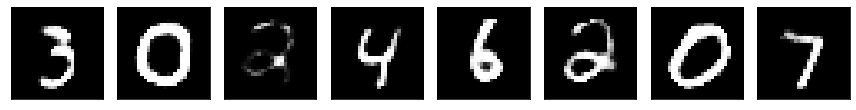

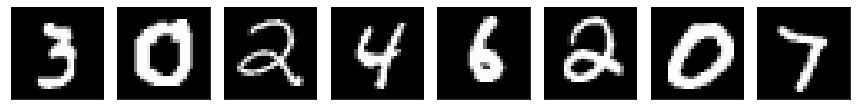

Test set


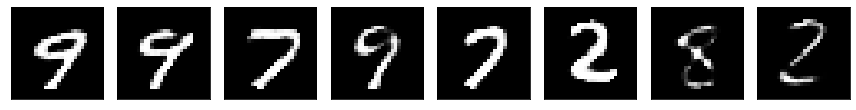

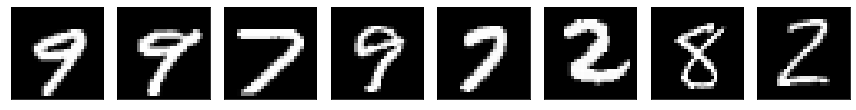

In [45]:
### BEGIN SOLUTION
# Plot reconstruction using the new model
ex_compare_reconstructions(model_2, train_set, test_set)
### END SOLUTION

## Exercise 7 : Plot the codes

As we can see we have succesfully encoded a 28x28 (=784) image into a 32-dimensional vector code.  This code compresses the information of the image by over 20 times and yet contains the information necessary to approximately reconstruct the image. The latent space of the code must have a certain structure to allow this.

Let's explore it by creating a **scatter plot** of the first two dimensions of the codes, and assigning a **different color to each digit**. Plot the **codes of 5% of the points in the training set**.

**Hint** consider using multiple calls to `plt.scatter` where each call plots the codes of a particular digit. Don't set the color of the points (keyword argument `c`) so that it automatically cycles over different colors. Set the `label` keyword argument of each scatter to the digit being plotted, this way the legend will have the correct information.

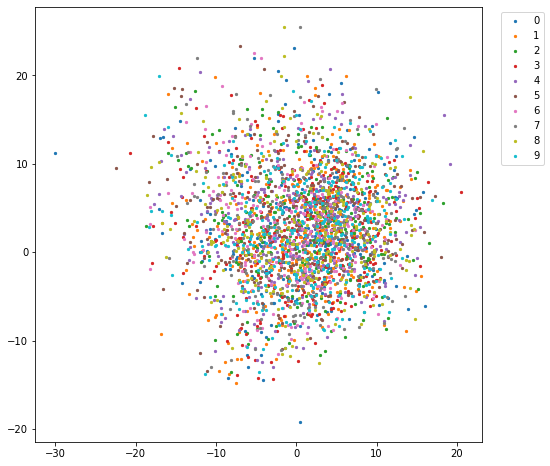

In [46]:
def ex_plot_codes(model, train_set):
    ### BEGIN SOLUTION
    # Forward the model on one batch
    dataloader = torch.utils.data.DataLoader(train_set, batch_size=int(len(train_set)*0.05), shuffle = True)
    
    was_training = model.eval()
    for it, data in enumerate(dataloader):
            ### BEGIN SOLUTION
            # Unpack the data into ims and labels
            ims = data[0]
            labels = data[1]
            
            # Forward pass of the model
            ims_est, codes = model(ims)
        
            break
    
    data_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
    for it, data in enumerate(dataloader):
        labels = data[1]
        
        for i in range(labels.shape[0]):
            
            data_dict[labels[i].item()].append(i)

        break
        
    # print(data_dict)    
    ### END SOLUTION

    # Move codes and labels back to the CPU and convert to numpy
    codes = codes.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()

    plt.figure(figsize=(8, 8))

    # For each digit
    for i in range(10):
        plt.scatter(codes[data_dict[i]][:,0], codes[data_dict[i]][:,1],s=5, label = i)
        ### BEGIN SOLUTION
        # print(len(codes[data_dict[i]][:,0]))
        # print(len(data_dict[i]))

        

        ### END SOLUTION
    plt.legend(bbox_to_anchor=(1.15, 1))
    plt.show()
    

ex_plot_codes(model_2, train_set)

## Exercise 8 : Plot the PCA of codes

In the previous visualisation we could start appreciating certain structure with points of same colour clustered together. This means that codes for the same digit are positioned close to each other.

However we were only plotting 2 dimensions of the 32 in the code. We may use a better projection to plot on a 2-dimensional plane by using a dimensionality reduction technique.

Re-do the plot from the previous exercise, this time by applying PCA in order to reduce to 2 dimensions.

We will use [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

(3000, 32)
(3000, 2)


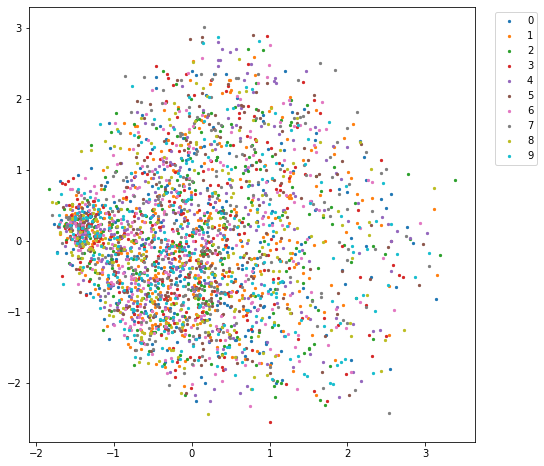

In [62]:
from sklearn.decomposition import PCA

def ex_plot_codes_pca(model, train_set):
    ### BEGIN SOLUTION
    # Forward the model on one batch
    dataloader = torch.utils.data.DataLoader(train_set, batch_size=int(len(train_set)*0.05), shuffle = True)
    
    was_training = model.eval()
    for it, data in enumerate(dataloader):
            ### BEGIN SOLUTION
            # Unpack the data into ims and labels
            ims = data[0]
            labels = data[1]
            
            # Forward pass of the model
            ims_est, codes = model(ims)
        
            break
    
    data_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
    for it, data in enumerate(dataloader):
        labels = data[1]
        
        for i in range(labels.shape[0]):
            
            data_dict[labels[i].item()].append(i)

        break
        
    # print(data_dict)    
    ### END SOLUTION

    # Move codes and labels back to the CPU and convert to numpy
    codes = codes.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    
    print(codes.shape)
    
    pca = PCA(n_components=2, whiten=True, svd_solver='full')
    pca.fit(codes)
    pca_code = pca.transform(codes)
    print(pca_code.shape)

    plt.figure(figsize=(8, 8))

    # For each digit
    for i in range(10):
        plt.scatter(pca_code[data_dict[i]][:,0], pca_code[data_dict[i]][:,1], s=5, label = i)
        # print(pca_code[data_dict[i]][:,0].shape)
        ### BEGIN SOLUTION
        # print(f"{i}: {len(data_dict[i])}")


        

        ### END SOLUTION
    plt.legend(bbox_to_anchor=(1.15, 1))
    plt.show()
    

ex_plot_codes_pca(model_2, train_set)

## Exercise 9 : Plot the TSNE of codes

With the PCA dimensionality reduction we are able to reveal more structure, but the linear projection of  PCA is not sufficient to represent the structure in such data. Instead we may use a non-linear method.

TSNE is an approach that can produce a low-dimensional embedding of the data that maintains local distribution of distances between points. Points that are close in the high-dimensional code space should be close in the low-dimensional space we embed in (2-D in our case for plotting.

Re-do the plot this time using a 2-D TSNE embedding.

We will use [`sklearn.manifold.TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

(3000, 32)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(3000, 2)


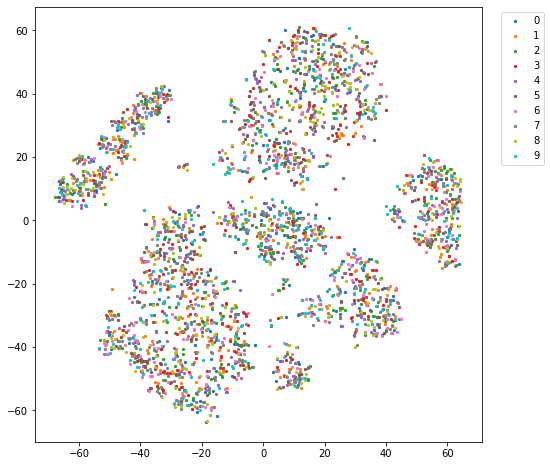

In [103]:
from locale import NOEXPR
from sklearn.manifold import TSNE

def ex_plot_codes_tsne(model, train_set):
    ### BEGIN SOLUTION
    # Forward the model on one batch
    dataloader = torch.utils.data.DataLoader(train_set, batch_size=int(len(train_set)*0.05), shuffle = True)
    
    was_training = model.eval()
    for it, data in enumerate(dataloader):
            ### BEGIN SOLUTION
            # Unpack the data into ims and labels
            ims = data[0]
            labels = data[1]
            
            # Forward pass of the model
            ims_est, codes = model(ims)
        
            break
    
    data_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
    for it, data in enumerate(dataloader):
        labels = data[1]
        
        for i in range(labels.shape[0]):
            
            data_dict[labels[i].item()].append(i)

        break
        
    # print(data_dict)    
    ### END SOLUTION

    # Move codes and labels back to the CPU and convert to numpy
    codes = codes.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    
    print(codes.shape)
    
    # pca = PCA(n_components=2, svd_solver='full')
    # pca.fit(codes)
    pca_code = TSNE(n_components=2, init='pca', n_iter=1000).fit_transform(codes)
    
    print(pca_code.shape)

    plt.figure(figsize=(8, 8))

    # For each digit
    for i in range(10):
        plt.scatter(pca_code[data_dict[i]][:,0], pca_code[data_dict[i]][:,1], s=5, label = i)
        # print(pca_code[data_dict[i]][:,0].shape)
        ### BEGIN SOLUTION
        # print(f"{i}: {len(data_dict[i])}")


        

        ### END SOLUTION
    plt.legend(bbox_to_anchor=(1.15, 1))
    plt.show()
    

ex_plot_codes_tsne(model_2, train_set)

## Exercise 10 : Classify using codes

As we see from the TSNE embedding the latent space of codes retains a structure related to the classes of the images. Note that no labels have been used in the training of the autoencoder nor the TSNE.

Lets see if this latent space is better suited for classifying the images than the pixel space directly.

Print the accuracy on the test set of two 5-nearest neighbour classifiers trained on 1% of the training set:

1. Classifier trained on pixel space
2. Classifier trained on latent space (codes)

We will use [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [66]:
from sklearn.neighbors import KNeighborsClassifier

def ex_compare_classifiers(model, train_set, test_set):
    # Forward a model on the train set
    batch_size = int(len(train_set) * 1/100)
    
    # Collect the images, codes and labels train
    train_x_pixel, train_x_latent, _, train_y = forward_one_batch(model, train_set, batch_size)

    # Flatten and convert to numpy the images, codes and labels
    train_x_pixel = train_x_pixel.flatten(1).detach().cpu().numpy()
    train_x_latent = train_x_latent.detach().cpu().numpy()
    train_y = train_y.detach().cpu().numpy()

    # Collect the images, codes and labels of test
    batch_size = len(test_set)
    test_x_pixel, test_x_latent, _, test_y = forward_one_batch(model, test_set, batch_size)

    # Flatten and convert to numpy the images, codes and labels
    test_x_pixel = test_x_pixel.flatten(1).detach().cpu().numpy()
    test_x_latent = test_x_latent.detach().cpu().numpy()
    test_y = test_y.detach().cpu().numpy()

    ### BEGIN SOLUTION
    # Create the image classifier
    neigh = KNeighborsClassifier(n_neighbors=10)
    
    # Train the classifier on train image data
    neigh.fit(train_x_pixel, train_y)


    # Evaluate the classifier on test image data
    pixel_acc = neigh.score(test_x_pixel,test_y)    

    # Create the codes classifier
    code_nei = KNeighborsClassifier(n_neighbors=10)

    # Train the classifier on train image data

    code_nei.fit(train_x_latent, train_y)

    # Evaluate the classifier on test image data
    latent_acc = code_nei.score(test_x_latent, test_y)
    ### END SOLUTION

    print(f'Pixel space accuracy: {pixel_acc:.2%}')
    print(f'Latent space accuracy: {latent_acc:.2%}')

ex_compare_classifiers(model_2, train_set, test_set)

Pixel space accuracy: 82.74%
Latent space accuracy: 84.62%


## Exercise 11 : Generate random images

Now we will see how to use our model to produce new images.

To do so we will pick a code at random and run a forward pass on the decoder. In order to pick plausible codes, we will sample them from a Gaussian fitted on the training set codes.

Generate and plot 8 random images:
- Find the mean and stddev of the codes of a 10% of the training data
- Create and sample 8 codes from a Normal with the mean and stddev found
- Run a forward pass of the decoder of our trained AE model on the generated codes
- Reshape the outputs of the decoder into MNIST-like images
- Plot the generated images

**Hint** you may use [`torch.distributions.normal.Normal`](https://pytorch.org/docs/stable/distributions.html#torch.distributions.normal.Normal) to build and sample from a Normal distribution.

torch.Size([6000, 32])
torch.Size([32])
torch.Size([32])


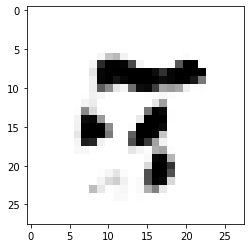

In [99]:
from torch.distributions.normal import Normal

def decode_images(model, codes):
    ### BEGIN SOLUTION


    # Forward of the decoder on the codes
    # print(codes.shape)
    codes = torch.unsqueeze(codes, 0)
    ims = model.decoder(codes)

    ### END SOLUTION
    return ims

def ex_generate_images(model, train_set):
    ### BEGIN SOLUTION
    # Forward of the model to obtain the codes (you may also only forward the encoder)
    batch_size = int(len(train_set) * 10/100)
    
    # Collect the images, codes and labels train
    ims, codes, ims_est, labels = forward_one_batch(model, train_set, batch_size)


    # Create a Normal distribution for the codes of 10% of training data
    print(codes.shape)
    mean = torch.mean(codes,0)
    std = torch.std(codes, 0)
    print(mean.shape)
    print(std.shape)
    m = Normal(mean, std)
    
    # print(sample_code.shape)

    # Sample codes
    sample_code = m.sample()

    # Forward of the decoder on the codes and reshape
    with torch.no_grad():
        gen_ims = decode_images(model, sample_code)
    ### END SOLUTION

    # Plot the images
    plt.imshow(gen_ims.squeeze(), cmap='gray_r')

ex_generate_images(model_2, train_set)

## (Optional) Exercise 11b : Generate particular digits

Do the same but fit the Gaussian distribution used for generating codes only on training data corresponding to the digit 0.

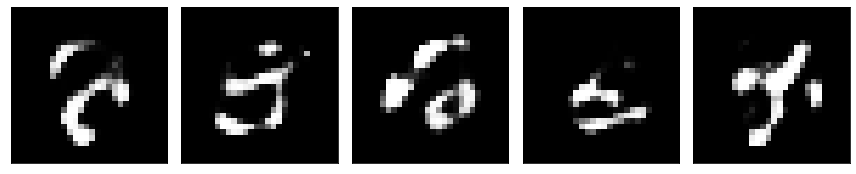

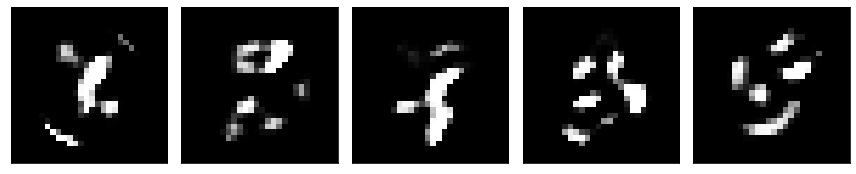

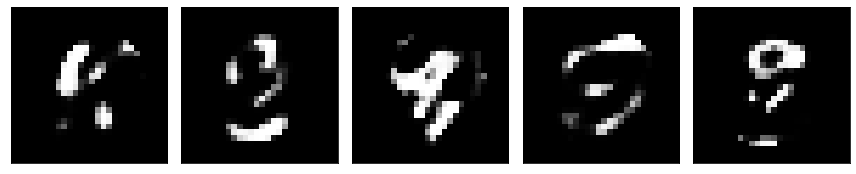

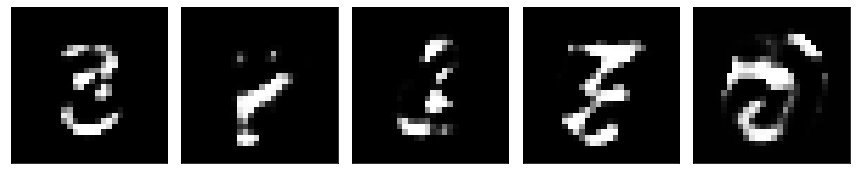

In [132]:
def ex_generate_digit_images(model, train_set, digit=0):
    ### BEGIN SOLUTION
    # Forward the model on 20% of the data

    batch_size = int(len(train_set) * 20/100)
    
    # Collect the images, codes and labels train
    ims, codes, ims_est, labels = forward_one_batch(model, train_set, batch_size)


    # Only keep codes corresponding to the digit given by the keyword argument
    logical = labels==digit
    indices = []
    for i,val in enumerate(logical):
        if val:
            indices.append(i)

    indices = torch.tensor(indices)
    
    our_codes = torch.index_select(codes, 0, indices)
    
    # Create a normal distribution with the mean and std
    mean = torch.mean(codes,0)
    std = torch.std(codes, 0)
    # print(mean.shape)
    # print(std.shape)
    m = Normal(mean, std)
    


    # Sample codes
    gen_ims = []
    for i in range(5):
        gen_code = m.sample()
        # Decode images
        with torch.no_grad():
        
            gen_ims.append(decode_images(model,gen_code).squeeze())
    ### END SOLUTION

    # Plot the images
    plot_images(gen_ims)
    # fig = plt.figure(figsize=(2,2))
    # plt.imshow(gen_ims.squeeze(), cmap='gray_r')
    # plt.xlabel(str(digit))

ex_generate_digit_images(model_2, train_set, digit=0)
ex_generate_digit_images(model_2, train_set, digit=1)
ex_generate_digit_images(model_2, train_set, digit=2)
ex_generate_digit_images(model_2, train_set, digit=3)

## Exercise 12 : Interpolate between images

Given that we can use any random code to generate images, one may ask what happens if we interpolate between the codes of two given images and decode into images the interpolated codes.

Create a function `encode_images` that computes the codes of a batch of images.

Create a function `interpolate_tensors` that takes as input a start tensor and end tensor and a number of steps and computes the linear interpolation between them at regular steps. Preferably use [`torch.lerp`](https://pytorch.org/docs/stable/generated/torch.lerp.html) to compute the interpolated vectors.

Finally implement the function `ex_compare_interpolation` that takes a model and a dataset. The function must interpolate in pixel space and code space the first and second images of the dataset. It must perform the interpolation in 8 steps and plot the resulting interpolation.

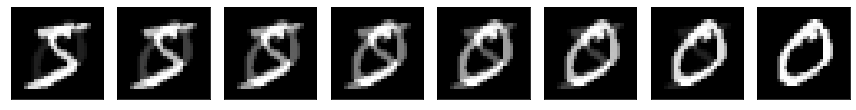

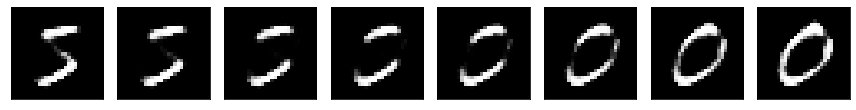

In [130]:
def encode_images(model, ims):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    ### BEGIN SOLUTION
    codes = model.encoder(ims)




    ### END SOLUTION
    return codes

def interpolate_tensors(start, end, steps):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    ### BEGIN SOLUTION
    # Create the weights
    # Weights are the normalized positions (from 0 to 1) where to interpolate
    #  between start and end
    # Weights must be broadcast compatible with the shapes 
    #  of start (dim,) and end (dim,)
    interp_codes = []
    for i in range(steps):
        interp_codes.append(torch.lerp(start, end, (i+1)/steps))

    # Compute the interpolation using torch.lerp

    ### END SOLUTION
    
    return interp_codes    

def ex_compare_interpolation(model, train_set):
    steps = 8
    im_first, y_first = train_set[0]
    im_last, y_last = train_set[1]

    ### BEGIN SOLUTION
    # Interpolate the images in pixel space
    interp_codes_pixel = interpolate_tensors(im_first, im_last, steps)
    # Interpolate the flattened images
    flat_first = im_first.flatten(1)
    flat_last = im_last.flatten(1)
    interp_codes_flattened =  interpolate_tensors(flat_first, flat_last, steps)
    # Reshape the flattened images into images
    images = []
    for i in interp_codes_flattened:
        images.append(torch.reshape(i, (28, 28)))

    # Plot the images

    plot_images(images)
    # Interpolate the images in latent space


    # Encode the images
    first_code = encode_images(model, im_first)
    last_code = encode_images(model, im_last)


    # Interpolate the codes
    interp_codes_latent = interpolate_tensors(first_code, last_code, steps) 

    # Decode the images from the interpolated codes
    decoded_images = []
    for i in interp_codes_latent:
        with torch.no_grad():
            j = i.squeeze()
            decoded_images.append(decode_images(model, j).squeeze())

    # Plot the images
    # print(decoded_images[0].shape)
    plot_images(decoded_images)

    ### END SOLUTION

ex_compare_interpolation(model_2, train_set)

## Exercise 13 : CNN Autoencoder

Let's now focus on reimplementing our Autoencoder to use convolutional layers.

Implement a `CNNAutoEncoder` with the following architecture for the `encoder`:

```
Conv2d(1, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
...
Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
...
Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
...
Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
...
Linear(out_features=32)
```

and the following one for the `decoder`:
```
Linear(out_features=588)
...
ConvTranspose2d(12, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
...
Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
...
ConvTranspose2d(12, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
...
Conv2d(6, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
...
```

Note that I have omitted the activations. Use rectified linear units as non-linearity. Use the same output activation as for the previous AutoEncoder. You may also require other layers such as `nn.Flatten` and `nn.Unflatten`.

Note that we use `nn.ConvTranspose2d` (or fractional-strided convolutions) in the decoder. These assume that the inputs are interleaved with zeros, larger strides have more zero-value samples between the input pixels. This way we can obtain growth in spatial resolution when decoding the image. See an illustration of a fractional-strided convolution here:

![https://theano-pymc.readthedocs.io/en/latest/_images/padding_strides_transposed.gif](https://theano-pymc.readthedocs.io/en/latest/_images/padding_strides_transposed.gif)

Note as well that in this particular choice of architecture we depart from a convolution with `base_nchan` output filters. We alternate between convolutions of stride 2 and those with stride 1. The second convolution of stride 2 doubles the number of output channels. The input (and output) dimensions of the `Linear` layers in the encoder (and decoder) will depend on the `base_nchan`. For example, with the particular choice of `base_nchan=6` the `Linear` layer in the encoder will have an input dimension of `588`. However in the next cell we set the `base_nchan=4`, in this case input dimension of the `Linear` layer of the encoder will be different.

To find the correct computed value keep track of the sizes of the feature maps after each convolution and you will have to set the dimension of the `Linear` layers to something as follows:
```
XXX * YYY * (2*base_nchan)
```

for which you'll have to find the values of `XXX` and `YYY`. 

In [ ]:
class CNNAutoEncoder(nn.Module):
    def __init__(self, input_shape, code_dim=32, base_nchan=6):
        super().__init__()

        input_nchan, _, _ = input_shape

        self.encoder = nn.Sequential(
            ### BEGIN SOLUTION










            ### END SOLUTION
        )

        self.decoder = nn.Sequential(
            ### BEGIN SOLUTION











            ### END SOLUTION
        )

    def forward(self, ims):
        ### BEGIN SOLUTION


        ### END SOLUTION
        return ims_est, codes

input_shape = train_set[0][0].shape
dummy = CNNAutoEncoder(input_shape, code_dim=32, base_nchan=6)

## Exercise 14 : CNN Autoencoder training and analysis

Train the newly created CNN AE.

And perform all the previous exercises on it. Simply run all the functions starting with `ex_...`.

Discuss the results.

In [ ]:
input_shape = train_set[0][0].shape
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
model_3 = CNNAutoEncoder(input_shape, code_dim=32, base_nchan=4)
train(model_3, train_loader, nepochs=3)

ep: 0, it: 0, loss : 0.01764
ep: 0, it: 100, loss : 0.01632
ep: 0, it: 200, loss : 0.01406
ep: 0, it: 300, loss : 0.01212
ep: 0, it: 400, loss : 0.00546
ep: 0, it: 500, loss : 0.00418
ep: 0, it: 600, loss : 0.00409
ep: 0, it: 700, loss : 0.00395
ep: 0, it: 800, loss : 0.00364
ep: 0, it: 900, loss : 0.00326
ep: 1, it: 0, loss : 0.00312
ep: 1, it: 100, loss : 0.00284
ep: 1, it: 200, loss : 0.00260
ep: 1, it: 300, loss : 0.00241
ep: 1, it: 400, loss : 0.00221
ep: 1, it: 500, loss : 0.00200
ep: 1, it: 600, loss : 0.00182
ep: 1, it: 700, loss : 0.00165
ep: 1, it: 800, loss : 0.00157
ep: 1, it: 900, loss : 0.00142
ep: 2, it: 0, loss : 0.00141
ep: 2, it: 100, loss : 0.00131
ep: 2, it: 200, loss : 0.00126
ep: 2, it: 300, loss : 0.00123
ep: 2, it: 400, loss : 0.00117
ep: 2, it: 500, loss : 0.00115
ep: 2, it: 600, loss : 0.00112
ep: 2, it: 700, loss : 0.00108
ep: 2, it: 800, loss : 0.00107
ep: 2, it: 900, loss : 0.00102


Plot reconstructions
Train set


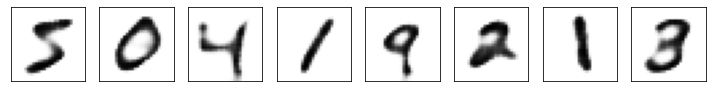

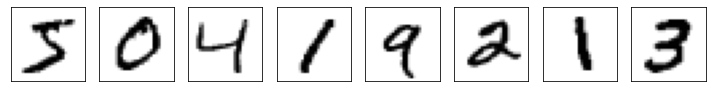

Test set


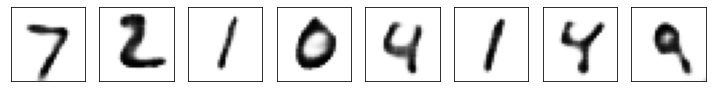

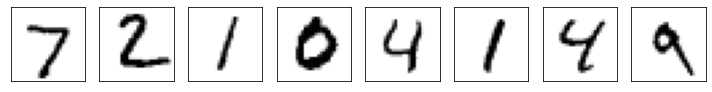

Plot the TSNE of codes


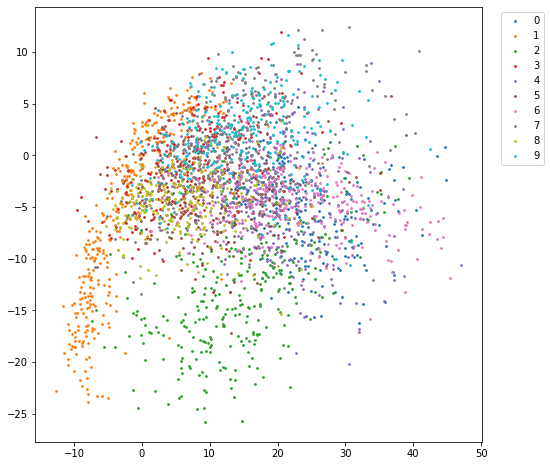

Plot the PCA of codes


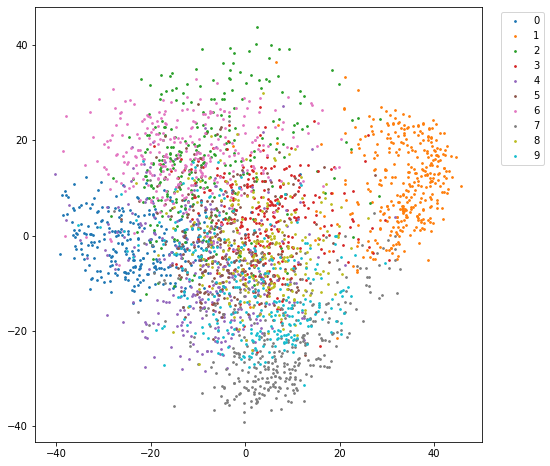

Plot the TSNE of codes
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.232s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 8.726775
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.460480
[t-SNE] KL divergence after 1000 iterations: 1.207533


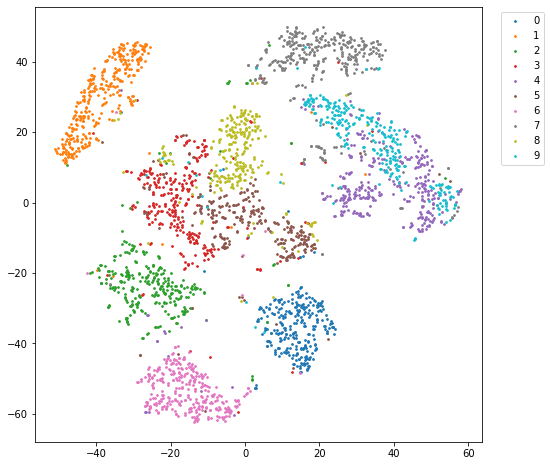

Classify using codes
Pixel space accuracy: 81.20%
Latent space accuracy: 83.73%
Generate random images


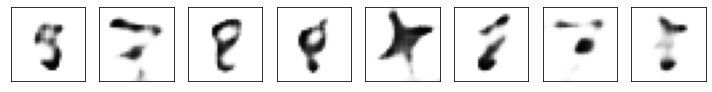

Generate particular digits


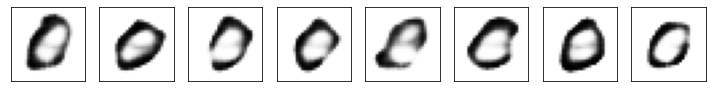

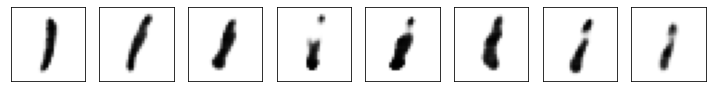

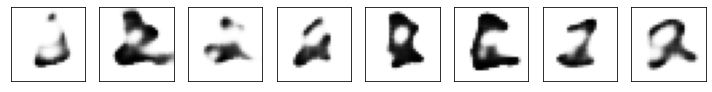

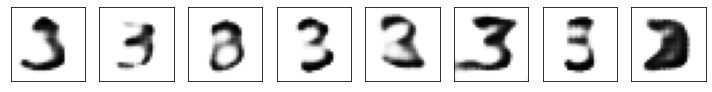

Interpolate between images
Interpolating in pixel space


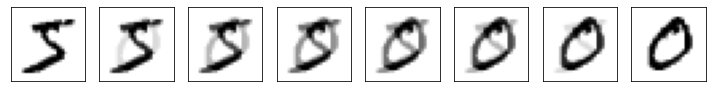

Interpolating in latent space


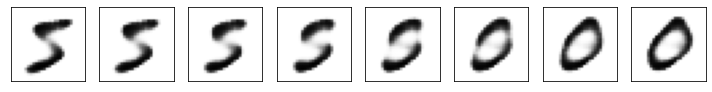

In [ ]:
print('Plot reconstructions')
ex_compare_reconstructions(model_3, train_set, test_set)

print('Plot the 1st and 2nd dimensions of codes')
ex_plot_codes(model_3, train_set)

print('Plot the PCA of codes')
ex_plot_codes_pca(model_3, train_set)

print('Plot the TSNE of codes')
ex_plot_codes_tsne(model_3, train_set)

print('Classify using codes')
ex_compare_classifiers(model_3, train_set, test_set)

print('Generate random images')
ex_generate_images(model_3, train_set)

print('Generate particular digits')
ex_generate_digit_images(model_3, train_set, digit=0)
ex_generate_digit_images(model_3, train_set, digit=1)
ex_generate_digit_images(model_3, train_set, digit=2)
ex_generate_digit_images(model_3, train_set, digit=3)

print('Interpolate between images')
ex_compare_interpolation(model_3, train_set)

## (Optional) Exercise 15 : Denoising Autoencoder

When we implemented our AE we decided that the task of the AE would take as input the original images and would have to reconstruct that same input.

This does not need to be so. Perhaps we may input a noisy version of the image and train the AE to reconstruct the clean version of the image.

Let's try to do this. We will first create a new dataset class `DenoisingDataset`, that takes as input an existing dataset and a transform function that should produce a distorted version of the input to be used as input to the AE.


**Note** that we can use `torchvision.transforms.Transform` classes as transforms here. As so, if we want to reproduce the setup of the original Autoencoder we can simply pass `transforms.Lambda(lambda x: x)` as a transform (which will leave the input unchanged).

Based on the previous `train` function, implement a new `train_denoising` function that accommodates the output of `DenoisingDataset`.

In [ ]:
class DenoisingDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        super().__init__()

        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]

        input = data[0]
        transformed_input = self.transform(input)

        return (transformed_input, ) + data

train_set_2 = DenoisingDataset(train_set, transform=transforms.Lambda(lambda x: x))

In [ ]:
def train_d(model, dataloader, nepochs=1, lr=1e-3):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.train()

    ### BEGIN SOLUTION
    # Create the Adam optimizer with weight_decay=1e-5


    # Create the MSE criterion

    ### END SOLUTION

    # Move model and criterion to the device
    model = model.to(device)
    criterion = criterion.to(device)

    # Variables to track the running average of the loss
    running_loss = 0.
    running_samples = 0

    for epoch in range(nepochs):
        for it, data in enumerate(dataloader):
            ### BEGIN SOLUTION
            # Unpack the data into ims and labels


            # Move ims into the device



            # Zero the gradients


            # Forward pass of the model


            # Compute the loss

            ### END SOLUTION

            running_loss += loss
            running_samples += ims.shape[0]

            if it % 100 == 0:
                print(f'ep: {epoch}, it: {it}, loss : {running_loss/running_samples:.5f}')
                running_loss = 0.
                running_samples = 0

            ### BEGIN SOLUTION
            # Compute the gradients


            # Perform optimization step

            ### END SOLUTION

## Exercise 16 : (Optional) Gaussian noise autoencoder

Now let's implement a Gaussian noise denoising AE. This AE is trained to reconstruct the clean version of images that have been corrupted using Gaussian additive noise.

We will implement two transforms (ie classes inheriting from `nn.Module`):
- `AddGaussianNoise` adds gaussian noise to input, with mean and std provided in the constructor
- `Clip` clips the input between min and max provided in the constructor

We then instantiate two `DenoisingDataset` (one for train and one for test) that use as transform a composition of both (see [`transforms.Compose`](https://pytorch.org/vision/stable/transforms.html#compositions-of-transforms)).

Finally train the model and plot an example of reconstruction.

**Note** we will be rewriting the previous functions for plotting `ex_compare_reconstructions` and forwarding a batch `forward_one_batch`.



In [ ]:
class AddGaussianNoise(nn.Module):
    def __init__(self, mean=0., std=1.):
        super().__init__()

        ### BEGIN SOLUTION


        ### END SOLUTION

    def forward(self, x):
        ### BEGIN SOLUTION


        ### END SOLUTION
        return y

class Clip(nn.Module):
    def __init__(self, min=0., max=1.):
        super().__init__()

        ### BEGIN SOLUTION


        ### END SOLUTION

    def forward(self, x):
        ### BEGIN SOLUTION

        ### END SOLUTION
        return y


noise_factor = 0.75

transform = transforms.Compose([AddGaussianNoise(0, noise_factor),
                                Clip(0, 1)])

train_gaussnoise_set = DenoisingDataset(train_set, 
                                        transform=transform)
test_gaussnoise_set = DenoisingDataset(test_set, 
                                       transform=transform)

input_shape = train_set[0][0].shape
train_loader = torch.utils.data.DataLoader(train_gaussnoise_set, batch_size=64)
model_4 = CNNAutoEncoder(input_shape, code_dim=32, base_nchan=4)
train_d(model_4, train_loader, nepochs=3)

ep: 0, it: 0, loss : 0.01073
ep: 0, it: 100, loss : 0.00641
ep: 0, it: 200, loss : 0.00431
ep: 0, it: 300, loss : 0.00422
ep: 0, it: 400, loss : 0.00431
ep: 0, it: 500, loss : 0.00392
ep: 0, it: 600, loss : 0.00344
ep: 0, it: 700, loss : 0.00295
ep: 0, it: 800, loss : 0.00262
ep: 0, it: 900, loss : 0.00200
ep: 1, it: 0, loss : 0.00182
ep: 1, it: 100, loss : 0.00168
ep: 1, it: 200, loss : 0.00154
ep: 1, it: 300, loss : 0.00148
ep: 1, it: 400, loss : 0.00141
ep: 1, it: 500, loss : 0.00137
ep: 1, it: 600, loss : 0.00131
ep: 1, it: 700, loss : 0.00126
ep: 1, it: 800, loss : 0.00125
ep: 1, it: 900, loss : 0.00118
ep: 2, it: 0, loss : 0.00119
ep: 2, it: 100, loss : 0.00114
ep: 2, it: 200, loss : 0.00112
ep: 2, it: 300, loss : 0.00112
ep: 2, it: 400, loss : 0.00109
ep: 2, it: 500, loss : 0.00110
ep: 2, it: 600, loss : 0.00108
ep: 2, it: 700, loss : 0.00105
ep: 2, it: 800, loss : 0.00105
ep: 2, it: 900, loss : 0.00101


Plot reconstructions
Train set


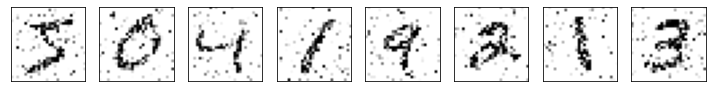

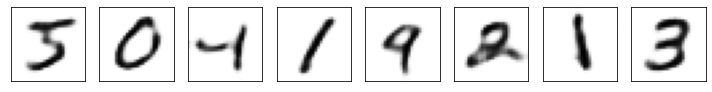

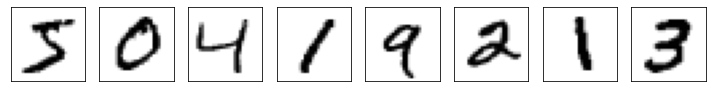

Test set


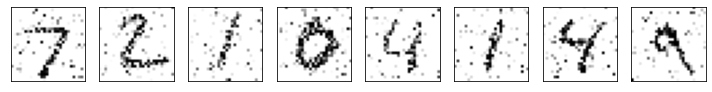

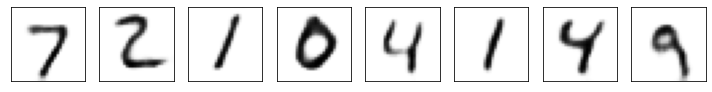

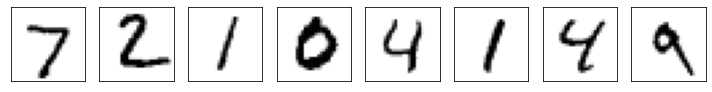

In [ ]:
def forward_one_batch_d(model, dataset, batch_size):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device)

    model.eval()

    ### BEGIN SOLUTION





    ### END SOLUTION

    return ims_in, ims_out, codes, ims_est, labels


def ex_compare_reconstructions_d(model, train_set, test_set):
    print('Train set')
    ### BEGIN SOLUTION


    ### END SOLUTION

    print('Test set')
    ### BEGIN SOLUTION


    ### END SOLUTION


print('Plot reconstructions')
ex_compare_reconstructions_d(model_4, train_gaussnoise_set, test_gaussnoise_set)

## Exercise 17 : (Optional) Imputation autoencoder

Now create an AE for which the input is the image with a patch of pixels in the center set to 0.

The patch set to 0 must be a square of 10x10 pixels in the center of the image.

Train the model and plot an example of reconstructions.

## (Bonus) Exercise 18 : CIFAR-10

Create a new CNN AutoEncoder model and train it on [CIFAR-10](https://pytorch.org/vision/stable/datasets.html#cifar). Note that the autoencoder will require modifications to accommodate the difference in number of channels and sizes of the images in the dataset.

Run all the exercises on this new autoencoder.

## (Bonus) Exercise 19 : MobileNet v2 as encoder for CIFAR-10

You may now modify the autoencoder so that it uses a MobileNet v2 feature extractor as encoder.

You may try fine-tuning or using a fixed version of the MobileNet v2 model pretrained on ImageNet.

As usual run all the exercises on this new autoencoder.

## (Bonus) Exercise 20 : Double-resolution autoencoder

We have seen so far AEs that don't change size between inputs and outputs. But we may well have some that don't (e.g. increase the image resolution). We will here create a model that upsamples by 2 an input image (doubles the height and width of the input image).

You may use the dataset of choice: MNIST or CIFAR-10.

Adapt the `CNNAutoEncoder` to create an AE model that doubles the resolution of input images. Make it take as input images of size 14x14 and outputs images of size 28x28.

Instantiate a `DenoisingDataset` that will return input images that are half-sized versions of the original ones.

Train the model and plot some examples.

## (Have fun) Exercise 21 : Train an AutoEncoder on any transformation of your choice

This time train an AE on whatever image transformation you can come up with. Let free your creativity and don't be afraid to test the limits of such auto-encoding approach.

The more original the transformation the better :-)